In [21]:
# Imported Libraries
import numpy as np
import pandas as pd 
import copy
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline

#Sampling Libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold

# Visual Libraries
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Performance metrics libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,auc
from sklearn.model_selection import ParameterGrid

# Tensorflow
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Lambda
from keras.losses import mse
from keras import regularizers
from keras import backend as K

from VAE import VAE_oversampling
import warnings
warnings.filterwarnings('ignore')

In [22]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
tf.random.set_seed(42)
random.seed(seed)

In [23]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Train, Validate, Test split

In [24]:
X = df.drop(['Class'], axis=1)
y = df['Class']

#Split data initially to train and remainingfor cross
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, stratify=y)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the validation dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")
print(f"The validation and test datasets have {sorted(Counter(y_test).items())[0][1]} records for the majority class and {sorted(Counter(y_test).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 227845
The number of records in the validation dataset is 56962
The training dataset has 227451 records for the majority class and 394 records for the minority class.
The validation and test datasets have 56864 records for the majority class and 98 records for the minority class.


In [25]:
def model_scores(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 score:", f1_score(y_true, y_pred))
    print("ROC_AUC:", roc_auc_score(y_true, y_pred))

In [26]:
def visualize_confusion_matrix(cf_matrix, axis):
    sns.heatmap(pd.DataFrame(cf_matrix), ax=axis, annot=True, cmap="YlGnBu" ,fmt='g')
    axis.set_title('Confusion matrix', y=1.1)
    axis.set_ylabel('Actual label')
    axis.set_xlabel('Predicted label')

In [27]:
def plot_roc_curve(model, y_true, X, axis):
    y_pred_proba = model.predict_proba(X)[::,1]

    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_proba)
    auc = metrics.roc_auc_score(y_true, y_pred_proba)

    #create ROC curve
    axis.plot(fpr,tpr)
    axis.set_ylabel('Sensitivity/TPR/Recall')
    axis.set_xlabel('Specificity/FPR')
    axis.set_title("ROC-AUC="+str(auc))
    #plt.legend(loc=4)

In [28]:
def model_cv(X_train, y_train, model, score, param_grid, sampling_technique = None):
    skf = StratifiedKFold(n_splits=5)

    if sampling_technique == 'smote':
        print("SMOTE applied")
        pipeline = Pipeline(steps = 
                            [['pre_process', StandardScaler()],
                             ['smote', SMOTE(random_state=1)],
                             ['classifier', model]])
    elif sampling_technique == 'original':
        print("Original applied")
        pipeline = Pipeline(steps = 
                            [['classifier', model]])
    else:
        pipeline = Pipeline(steps = 
                            [['pre_process', StandardScaler()],
                             ['classifier', model]])
                
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring = ['accuracy','precision','recall','f1','roc_auc'],
                               refit=score,
                               cv=skf,
                               n_jobs=-1)
    

    grid_search.fit(X_train, y_train)

    cv_results = pd.DataFrame(grid_search.cv_results_)
    best_model_results = cv_results.loc[grid_search.best_index_]

    print(f"Accuracy:, {best_model_results['mean_test_accuracy']:0.6f} (+/- {best_model_results['std_test_accuracy']:0.6f})")
    print(f"Precision: {best_model_results['mean_test_precision']:0.6f} (+/- {best_model_results['std_test_precision']:0.6f})")
    print(f"Recall: {best_model_results['mean_test_recall']:0.6f} (+/- {best_model_results['std_test_recall']:0.6f})")
    print(f"F1 score: {best_model_results['mean_test_f1']:0.6f} (+/- {best_model_results['std_test_f1']:0.6f})")
    print(f"ROC_AUC: {best_model_results['mean_test_roc_auc']:0.6f} (+/- {best_model_results['std_test_roc_auc']:0.6f})")

    print('Best hyperparameters: ', grid_search.best_params_)

    return grid_search

In [29]:
def evaluate_model(X_test, y_test, estimator):
    num_fraud_cases_in_test = len(y_test[y_test==1])
    num_normal_cases_in_test = len(y_test[y_test==0])
    
    predictions = estimator.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    
    # Plot normalized confusion matrix and precision recall curve
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    
    visualize_confusion_matrix(cm, axes[0])
    
    plot_roc_curve(estimator, y_test, X_test, axes[1])
    plt.tight_layout()
    
    # Print summary    
    print(f"\nClassified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
    print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")

    model_scores(y_test, predictions)
    #print(f"Average preicision score is {prc.average_precision:.4f}")
    
    #return [name, cm[1,1], cm[1,1]/num_fraud_cases_in_test*100, cm[0,1], prc.average_precision]

In [32]:
def model_cv(X_train, y_train, model, score, param_grid, sampling_technique = None):
    skf = StratifiedKFold(n_splits=5)

    if sampling_technique == 'smote':
        print("SMOTE applied")
        pipeline = Pipeline(steps = 
                            [['pre_process', StandardScaler()],
                             ['smote', SMOTE(random_state=1)],
                             ['classifier', model]])
    elif sampling_technique =='undersampling':
        pipeline = Pipeline(steps=
                            [['pre_process', StandardScaler()],
                                ['undersampling', RandomUnderSampler()],
                                ['classifier', model]])
    elif sampling_technique == 'original':
        print("Original applied")
        pipeline = Pipeline(steps = 
                            [['classifier', model]])
    else:
        pipeline = Pipeline(steps = 
                            [['pre_process', StandardScaler()],
                             ['classifier', model]])
                
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring = ['accuracy','precision','recall','f1','roc_auc'],
                               refit=score,
                               cv=skf,
                               n_jobs=-1)
    

    grid_search.fit(X_train, y_train)

    cv_results = pd.DataFrame(grid_search.cv_results_)
    best_model_results = cv_results.loc[grid_search.best_index_]

    print(f"Accuracy:, {best_model_results['mean_test_accuracy']:0.6f} (+/- {best_model_results['std_test_accuracy']:0.6f})")
    print(f"Precision: {best_model_results['mean_test_precision']:0.6f} (+/- {best_model_results['std_test_precision']:0.6f})")
    print(f"Recall: {best_model_results['mean_test_recall']:0.6f} (+/- {best_model_results['std_test_recall']:0.6f})")
    print(f"F1 score: {best_model_results['mean_test_f1']:0.6f} (+/- {best_model_results['std_test_f1']:0.6f})")
    print(f"ROC_AUC: {best_model_results['mean_test_roc_auc']:0.6f} (+/- {best_model_results['std_test_roc_auc']:0.6f})")

    print('Best hyperparameters: ', grid_search.best_params_)

    return grid_search

In [33]:
# Parameters and values to tune
param_grid_svc = dict(classifier__C = [0.1, 1], classifier__kernel = ['linear', 'rbf'], classifier__gamma= ['scale', 'auto'])

## Original Dataset Results

Original applied


Accuracy:, 0.998596 (+/- 0.000156)
Precision: 0.702531 (+/- 0.105809)
Recall: 0.334989 (+/- 0.043255)
F1 score: 0.452104 (+/- 0.055585)
ROC_AUC: 0.756155 (+/- 0.030959)
Best hyperparameters:  {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}


AttributeError: predict_proba is not available when  probability=False

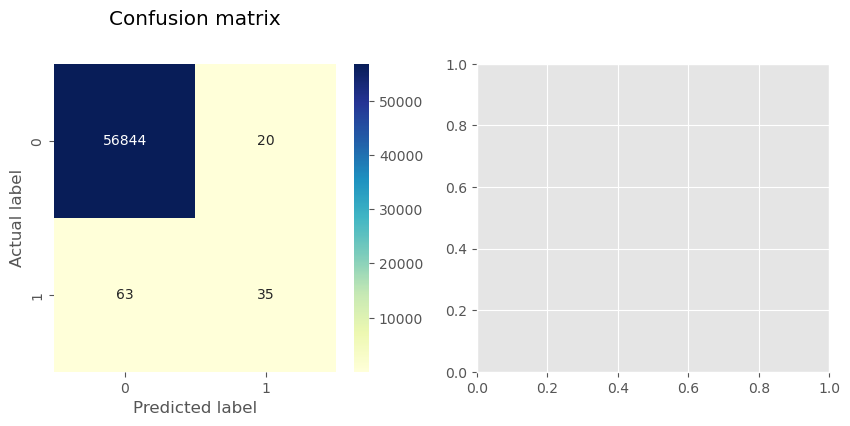

In [20]:
gs = model_cv(X_train, y_train, SVC(), 'f1', param_grid_svc, 'original')

evaluate_model(X_test, y_test, gs)

## Scaled

Accuracy:, 0.999513 (+/- 0.000043)
Precision: 0.945047 (+/- 0.028852)
Recall: 0.763843 (+/- 0.029514)
F1 score: 0.844080 (+/- 0.015627)
ROC_AUC: 0.947435 (+/- 0.011105)
Best hyperparameters:  {'classifier__max_depth': None, 'classifier__n_estimators': 100}

Classified 	79 out of 98 	fraud cases correctly
Misclassified 	4 out of 56864 normal cases
Accuracy: 0.9995962220427653
Precision: 0.9518072289156626
Recall: 0.8061224489795918
F1 score: 0.8729281767955801
ROC_AUC: 0.9030260528522045


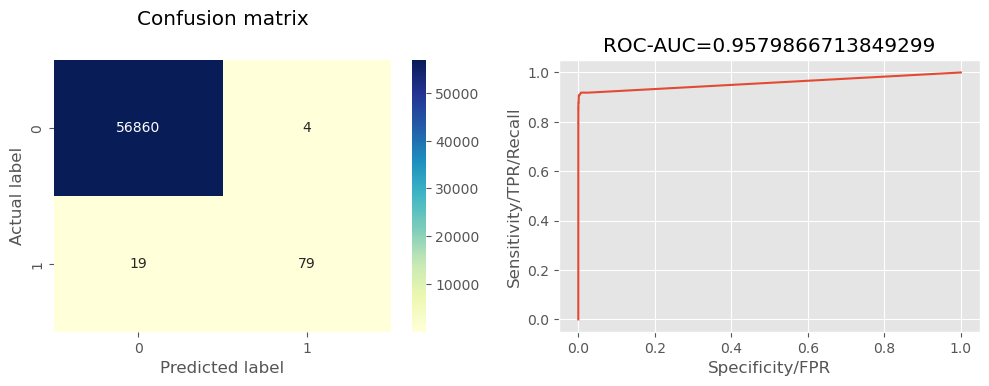

In [ ]:
gs = model_cv(X_train, y_train, SVC(), 'f1', param_grid_svc)

evaluate_model(X_test, y_test, gs)

## Random Undersampling

Accuracy:, 0.993131 (+/- 0.000352)
Precision: 0.178897 (+/- 0.006581)
Recall: 0.827199 (+/- 0.049524)
F1 score: 0.294039 (+/- 0.010727)
ROC_AUC: 0.979703 (+/- 0.009897)
Best hyperparameters:  {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

Classified 	83 out of 98 	fraud cases correctly
Misclassified 	462 out of 56864 normal cases
Accuracy: 0.9916259962782206
Precision: 0.15229357798165138
Recall: 0.8469387755102041
F1 score: 0.2581648522550544
ROC_AUC: 0.91940706361329


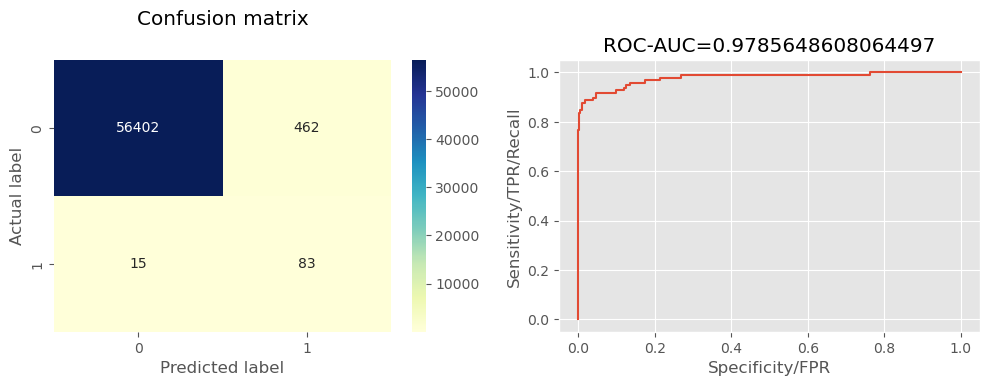

In [35]:
gs = model_cv(X_train, y_train, SVC(probability=True), "f1", param_grid_svc, 'undersampling')

evaluate_model(X_test, y_test, gs)

## Oversampling with SMOTE

SMOTE applied


Accuracy:, 0.999513 (+/- 0.000100)
Precision: 0.897086 (+/- 0.050330)
Recall: 0.814606 (+/- 0.031423)
F1 score: 0.852840 (+/- 0.028102)
ROC_AUC: 0.976783 (+/- 0.011840)
Best hyperparameters:  {'classifier__max_depth': None, 'classifier__n_estimators': 100}

Classified 	81 out of 98 	fraud cases correctly
Misclassified 	11 out of 56864 normal cases
Accuracy: 0.9995084442259752
Precision: 0.8804347826086957
Recall: 0.826530612244898
F1 score: 0.8526315789473684
ROC_AUC: 0.9131685841190725


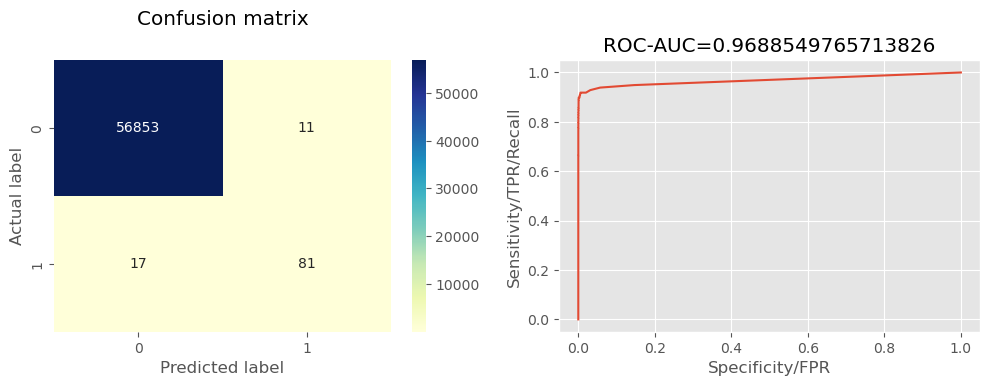

In [ ]:
gs = model_cv(X_train, y_train, SVC(), 'f1', param_grid_svc, 'smote')

evaluate_model(X_test, y_test, gs)

## Oversampling with VAE

### Hyperparameter Tuning with cross validation

############################### Parameters tested: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 34.6701 - val_loss: 29.1231
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.9345 - val_loss: 26.2609
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.7334 - val_loss: 25.9735
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.4655 - val_loss: 25.9305
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 28.0678 - val_loss: 26.0238
Epoch 6/100
284/284 [==========================

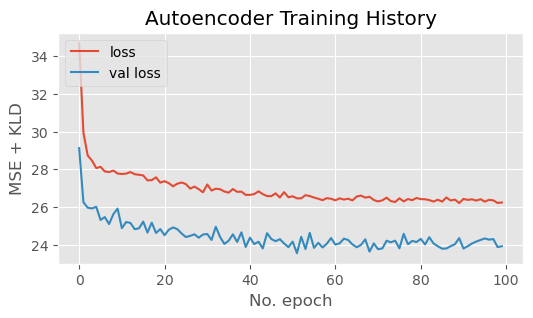

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 34.9144 - val_loss: 28.9892
Epoch 2/100
283/283 [==============================] - 2s 5ms/step - loss: 30.2848 - val_loss: 25.9365
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.5376 - val_loss: 24.8687
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.2183 - val_loss: 25.0030
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.0882 - val_loss: 24.6777
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8621 - val_loss: 24.9806
Epoch 7/100
283/283

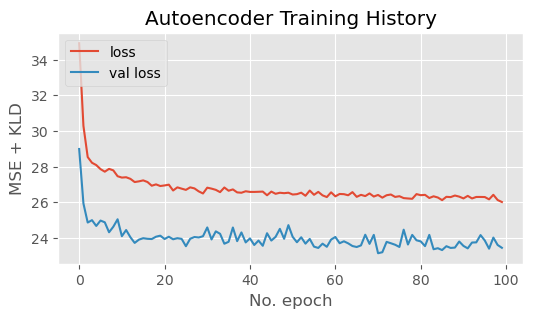

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 6ms/step - loss: 35.0524 - val_loss: 28.8591
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 30.5757 - val_loss: 25.6671
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.6773 - val_loss: 25.0686
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.5020 - val_loss: 24.6251
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.1228 - val_loss: 24.2751
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1168 - val_loss: 24.2972
Epoch 7/100
283/283

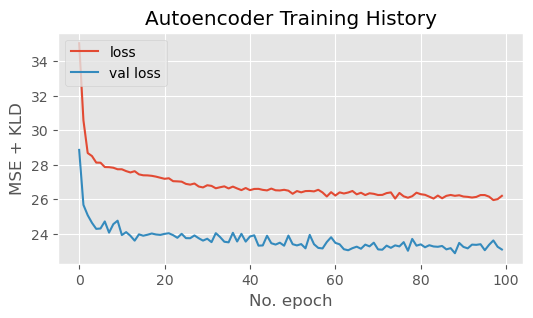

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 35.2215 - val_loss: 29.5793
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.8557 - val_loss: 26.7854
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.3028 - val_loss: 26.2396
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.0992 - val_loss: 26.1062
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8539 - val_loss: 26.0159
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8095 - val_loss: 25.4163
Epoch 7/100
283/283

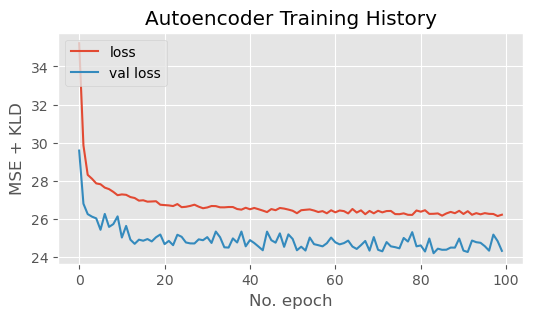

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 6ms/step - loss: 33.9504 - val_loss: 38.7430
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 28.7094 - val_loss: 36.4517
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 27.3518 - val_loss: 36.0370
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 26.8203 - val_loss: 35.9105
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 26.5664 - val_loss: 36.0520
Epoch 6/100
283/283 [==============================] - 1s 5ms/step - loss: 26.5390 - val_loss: 35.5916
Epoch 7/100
283/283 

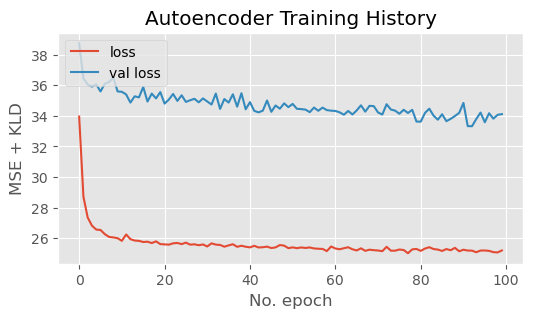

5677/5677 [==============================] - 9s 2ms/step
############################### Parameters tested: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 34.2549 - val_loss: 29.3578
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.8193 - val_loss: 26.2355
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.4901 - val_loss: 26.6694
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.2104 - val_loss: 25.6415
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 27.8093 - val_loss: 2

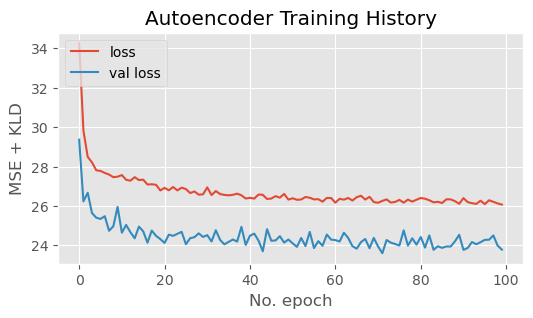

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.5207 - val_loss: 29.7737
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 31.0383 - val_loss: 26.1178
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.9537 - val_loss: 24.9515
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6942 - val_loss: 25.1775
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1570 - val_loss: 24.6174
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0019 - val_loss: 24.6439
Epoch 7/100
283/283

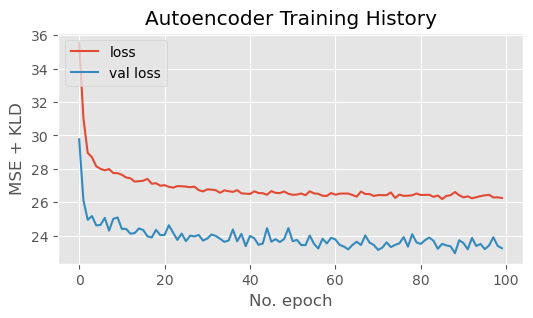

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.0877 - val_loss: 28.3209
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.0700 - val_loss: 25.6413
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6286 - val_loss: 24.8698
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6057 - val_loss: 24.7678
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1058 - val_loss: 24.3640
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0253 - val_loss: 24.0857
Epoch 7/100
283/283 

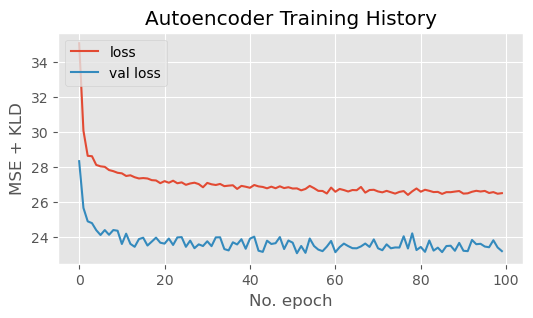

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 6ms/step - loss: 34.6343 - val_loss: 29.3406
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.7244 - val_loss: 26.3985
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1933 - val_loss: 25.8867
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0556 - val_loss: 25.7937
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.6421 - val_loss: 25.9235
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.6007 - val_loss: 25.6440
Epoch 7/100
283/283 

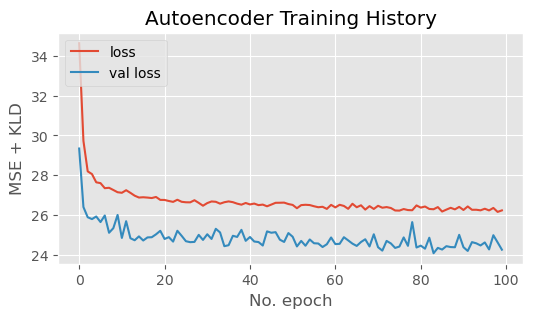

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.7256 - val_loss: 39.2931
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.6247 - val_loss: 36.9945
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7185 - val_loss: 36.3766
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 27.0889 - val_loss: 35.7786
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 26.6381 - val_loss: 35.6949
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 26.7128 - val_loss: 35.2286
Epoch 7/100
283/283 

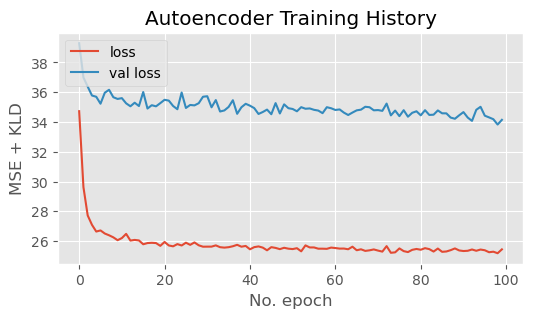

5677/5677 [==============================] - 9s 1ms/step
############################### Parameters tested: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 34.7163 - val_loss: 28.8417
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.5897 - val_loss: 25.7860
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.4026 - val_loss: 25.5380
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.0392 - val_loss: 25.2170
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 27.8695 - val_loss:

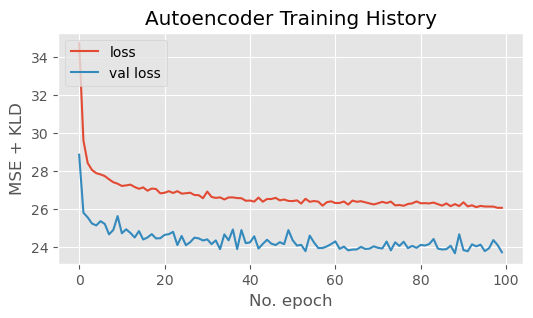

5677/5677 [==============================] - 9s 1ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 34.8101 - val_loss: 28.9635
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.9809 - val_loss: 25.6046
Epoch 3/100
283/283 [==============================] - 2s 7ms/step - loss: 28.4769 - val_loss: 25.3534
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0729 - val_loss: 24.8364
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.9000 - val_loss: 24.3564
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7920 - val_loss: 25.1116
Epoch 7/100
283/283 

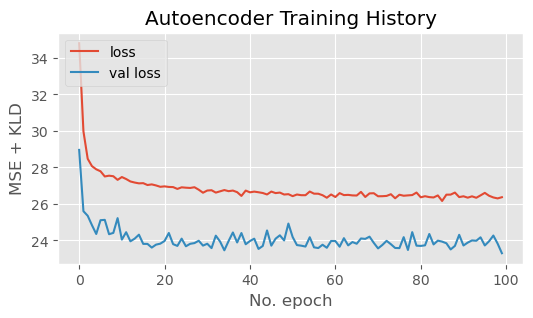

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 6ms/step - loss: 34.2591 - val_loss: 28.1209
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.8490 - val_loss: 24.9495
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5344 - val_loss: 24.8215
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5428 - val_loss: 24.4986
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1692 - val_loss: 24.2234
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1320 - val_loss: 24.2652
Epoch 7/100
283/283

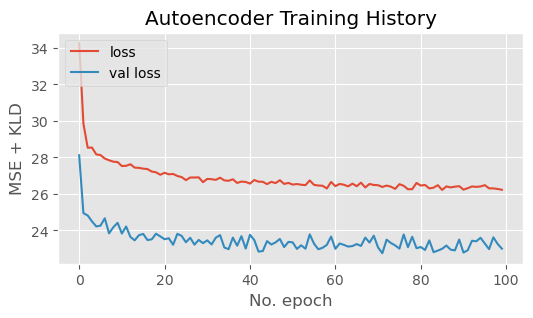

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 6ms/step - loss: 34.8617 - val_loss: 30.1210
Epoch 2/100
283/283 [==============================] - 2s 5ms/step - loss: 30.6472 - val_loss: 27.0116
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.8563 - val_loss: 26.3677
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.1217 - val_loss: 26.1252
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.0350 - val_loss: 26.1395
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.6306 - val_loss: 25.8450
Epoch 7/100
283/283

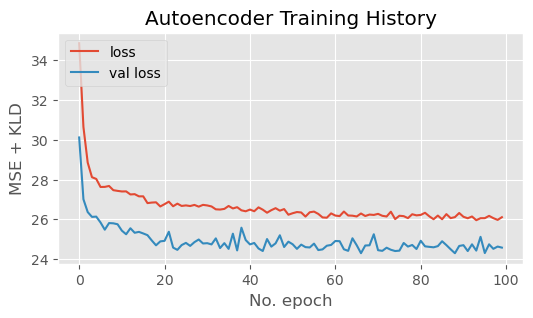

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 33.8891 - val_loss: 38.2519
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 28.4357 - val_loss: 36.4100
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 27.2943 - val_loss: 36.0935
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 26.9737 - val_loss: 35.8102
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 26.6038 - val_loss: 35.8290
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 26.5362 - val_loss: 35.7690
Epoch 7/100
283/283

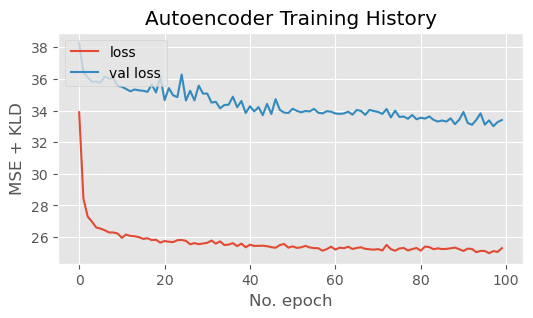

5677/5677 [==============================] - 8s 1ms/step
############################### Parameters tested: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 5ms/step - loss: 34.9337 - val_loss: 28.6518
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 30.0754 - val_loss: 26.0262
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 28.6375 - val_loss: 25.5229
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 28.2007 - val_loss: 25.3533
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 27.8931 - val_loss: 25

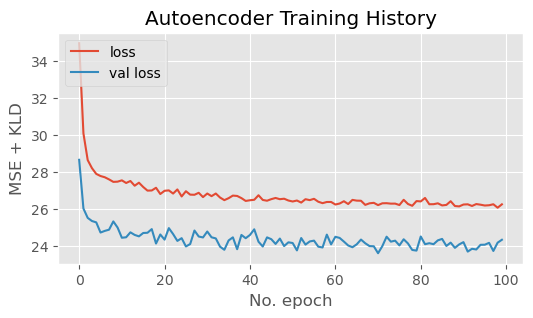

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.6067 - val_loss: 27.5558
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.8987 - val_loss: 25.5956
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.7011 - val_loss: 25.0230
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2232 - val_loss: 24.6933
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0377 - val_loss: 24.6054
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8731 - val_loss: 24.3385
Epoch 7/100
283/283 

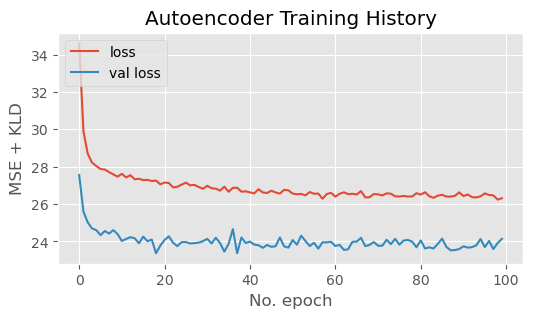

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.0116 - val_loss: 27.9790
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.9593 - val_loss: 24.9504
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3972 - val_loss: 24.8493
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2812 - val_loss: 24.3092
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0866 - val_loss: 24.3685
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9718 - val_loss: 23.9668
Epoch 7/100
283/283 

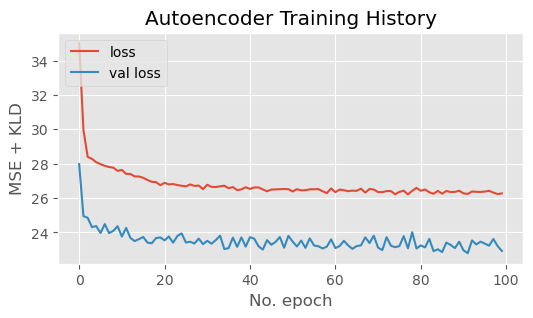

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.2256 - val_loss: 29.5829
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.3677 - val_loss: 26.8273
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.5649 - val_loss: 26.2759
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.1882 - val_loss: 26.0286
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2086 - val_loss: 26.1611
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8642 - val_loss: 25.5438
Epoch 7/100
283/283

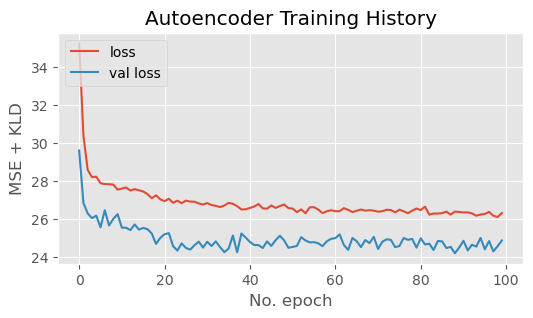

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.3302 - val_loss: 38.8013
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.0191 - val_loss: 36.0504
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 27.6313 - val_loss: 35.8358
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0834 - val_loss: 36.4655
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0790 - val_loss: 35.6177
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 26.6735 - val_loss: 36.0113
Epoch 7/100
283/283

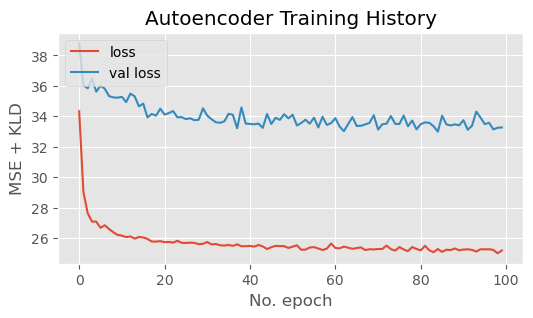

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 5ms/step - loss: 34.7030 - val_loss: 29.2973
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.8007 - val_loss: 25.8902
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.5549 - val_loss: 26.3670
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.2502 - val_loss: 25.6404
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 27.9037 - val_loss:

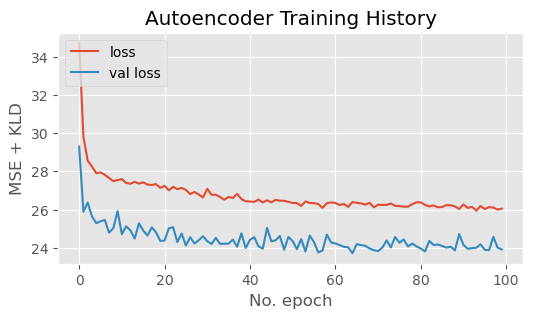

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.7538 - val_loss: 28.4998
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.9981 - val_loss: 25.3431
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5309 - val_loss: 25.1020
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1613 - val_loss: 24.7890
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1277 - val_loss: 24.5960
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.9624 - val_loss: 24.6952
Epoch 7/100
283/283

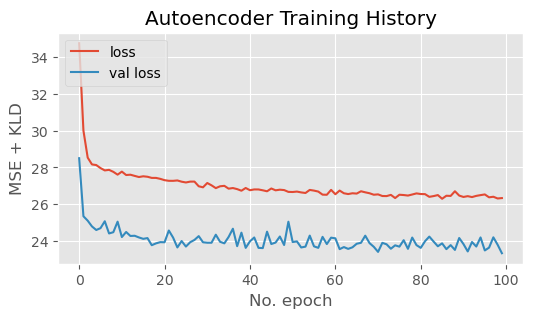

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 4s 11ms/step - loss: 34.6559 - val_loss: 28.0981
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.8113 - val_loss: 25.1774
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.7110 - val_loss: 24.7644
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.7417 - val_loss: 24.6279
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.2511 - val_loss: 24.5778
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.2080 - val_loss: 24.3906
Epoch 7/100
283/28

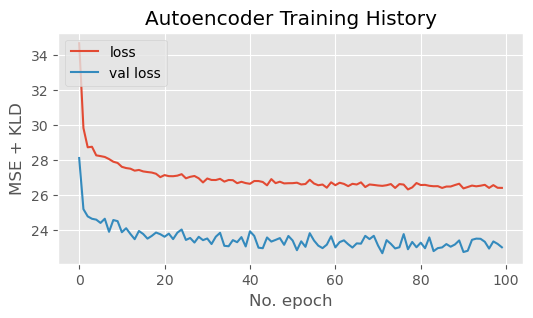

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.1530 - val_loss: 29.9775
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.8718 - val_loss: 26.6116
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6383 - val_loss: 25.9605
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.3852 - val_loss: 25.9866
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.7990 - val_loss: 25.6204
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.7304 - val_loss: 25.6949
Epoch 7/100
283/283

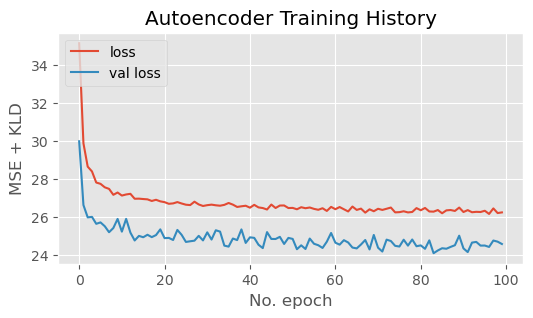

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.5638 - val_loss: 39.5736
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.0235 - val_loss: 37.2715
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8653 - val_loss: 36.2349
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.4025 - val_loss: 35.9947
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 26.9532 - val_loss: 36.2897
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0296 - val_loss: 35.9401
Epoch 7/100
283/283

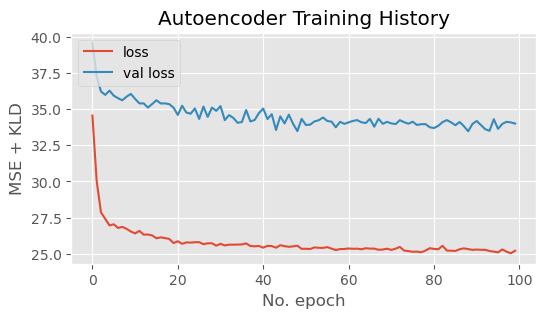

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 3s 5ms/step - loss: 35.1578 - val_loss: 29.6514
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 30.3208 - val_loss: 26.3101
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 28.6499 - val_loss: 25.7989
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 28.3280 - val_loss: 25.5878
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 27.9118 - val_loss: 25

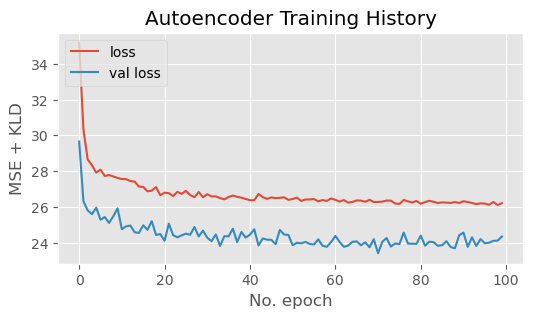

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.2435 - val_loss: 29.6958
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.6143 - val_loss: 26.3857
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.9727 - val_loss: 25.1366
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3599 - val_loss: 24.5767
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0187 - val_loss: 24.8201
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0775 - val_loss: 24.4514
Epoch 7/100
283/283

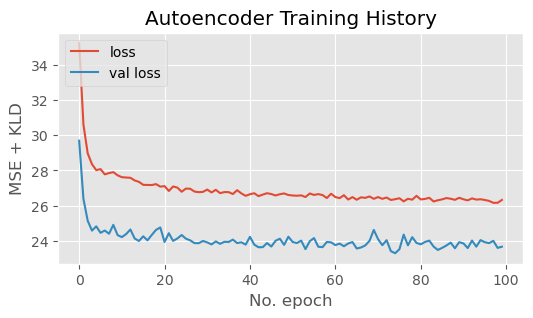

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.4356 - val_loss: 28.4558
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.3555 - val_loss: 25.2218
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.5267 - val_loss: 25.0791
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3917 - val_loss: 24.3669
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2531 - val_loss: 24.3319
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9404 - val_loss: 23.9862
Epoch 7/100
283/283 

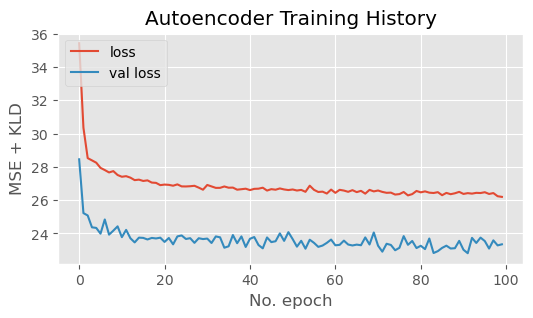

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.2417 - val_loss: 30.0983
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.2886 - val_loss: 27.0115
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.8055 - val_loss: 26.0234
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3562 - val_loss: 25.7388
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8913 - val_loss: 26.1913
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9487 - val_loss: 25.9927
Epoch 7/100
283/283 

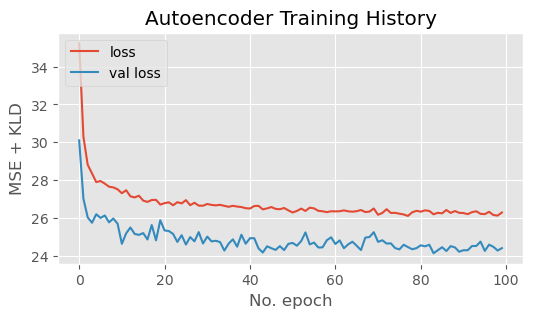

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.4984 - val_loss: 39.7974
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.9423 - val_loss: 37.2278
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 27.6532 - val_loss: 36.2505
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0011 - val_loss: 35.7767
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 26.5759 - val_loss: 35.8427
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 26.5583 - val_loss: 35.8878
Epoch 7/100
283/283

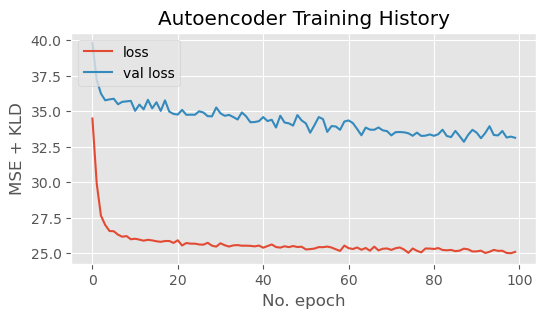

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 35.3966 - val_loss: 29.7401
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 30.3218 - val_loss: 26.4509
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.4970 - val_loss: 25.6525
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.2481 - val_loss: 25.6873
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 28.1201 - val_loss: 

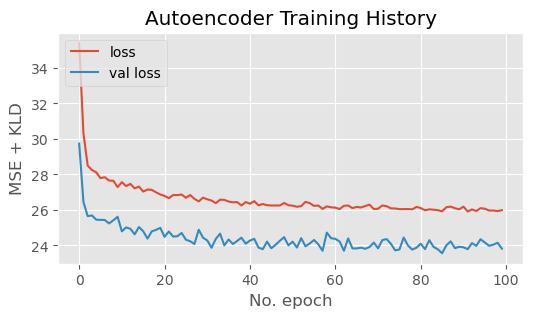

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.2452 - val_loss: 28.9034
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.2283 - val_loss: 25.7349
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.7632 - val_loss: 25.2904
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5511 - val_loss: 25.1630
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1698 - val_loss: 24.9277
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.2412 - val_loss: 24.8467
Epoch 7/100
283/283

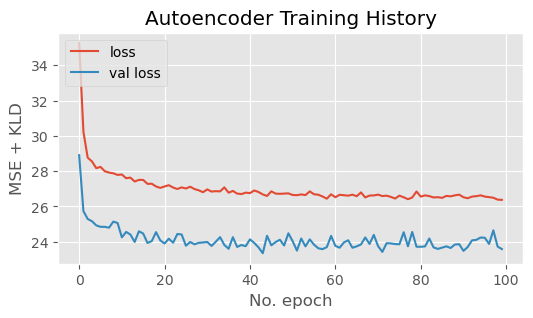

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.4612 - val_loss: 28.7005
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.2425 - val_loss: 25.3061
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.7667 - val_loss: 25.1145
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.6493 - val_loss: 24.4611
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9960 - val_loss: 24.0321
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0446 - val_loss: 24.3938
Epoch 7/100
283/283

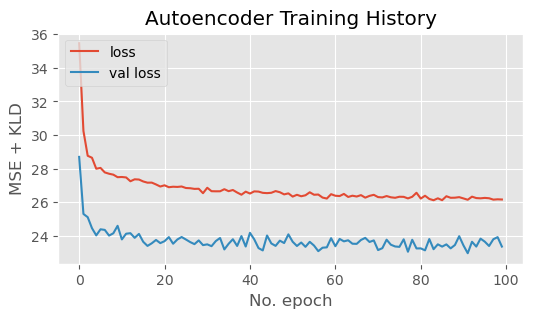

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 35.1139 - val_loss: 29.2485
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.9002 - val_loss: 26.8695
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4669 - val_loss: 26.1888
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9186 - val_loss: 25.7551
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0315 - val_loss: 25.7557
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.5094 - val_loss: 25.2411
Epoch 7/100
283/283

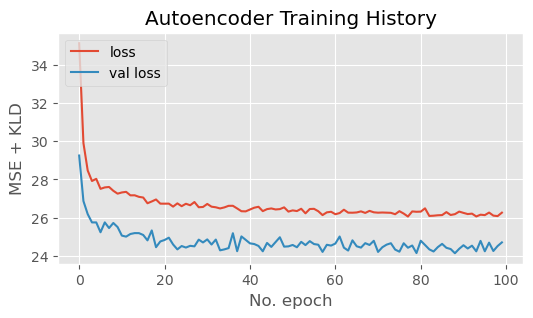

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.4626 - val_loss: 39.2074
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.1639 - val_loss: 36.4864
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 27.4752 - val_loss: 36.0847
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 26.8751 - val_loss: 36.2114
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 26.6748 - val_loss: 35.5406
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 26.5012 - val_loss: 36.3456
Epoch 7/100
283/283

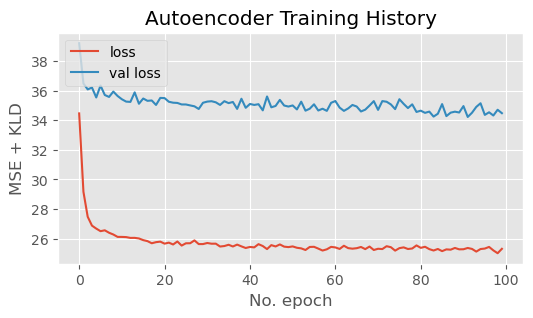

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 5ms/step - loss: 35.3641 - val_loss: 30.3064
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 30.7636 - val_loss: 26.5527
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.9748 - val_loss: 25.7751
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.5033 - val_loss: 25.8679
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 28.0704 - val_loss: 25.

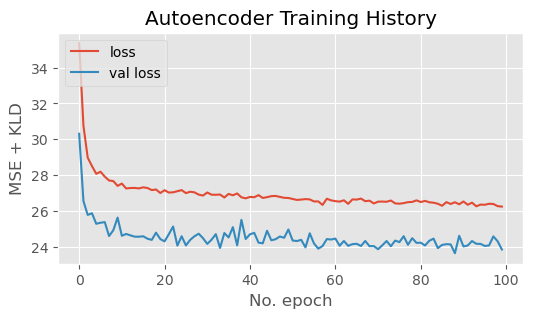

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 6ms/step - loss: 34.6635 - val_loss: 27.2498
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.6291 - val_loss: 25.4348
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5815 - val_loss: 24.9955
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0998 - val_loss: 24.6783
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1168 - val_loss: 24.7405
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7765 - val_loss: 24.1554
Epoch 7/100
283/283

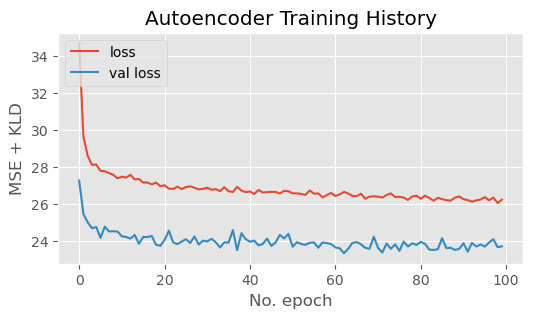

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.2570 - val_loss: 28.1359
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.3607 - val_loss: 25.3245
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6938 - val_loss: 24.8541
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1781 - val_loss: 24.6652
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1310 - val_loss: 24.4945
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8493 - val_loss: 23.8977
Epoch 7/100
283/283

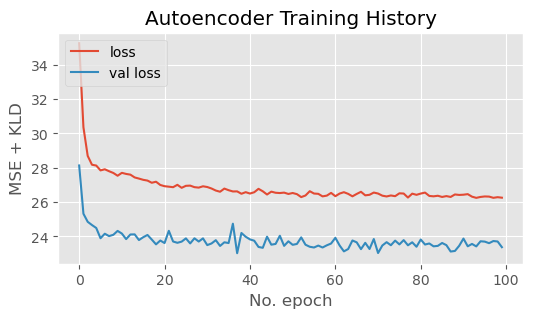

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.3849 - val_loss: 29.5866
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.2900 - val_loss: 26.7515
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5567 - val_loss: 25.8918
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9854 - val_loss: 25.7336
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9921 - val_loss: 25.8407
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.6547 - val_loss: 25.4044
Epoch 7/100
283/283

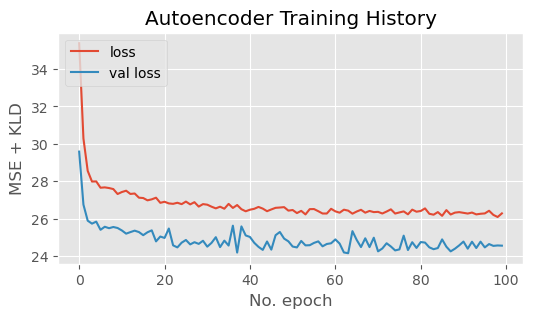

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.4904 - val_loss: 39.2272
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.2603 - val_loss: 37.0879
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 27.3900 - val_loss: 36.0542
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0070 - val_loss: 35.6608
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 26.5400 - val_loss: 36.1148
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 26.4903 - val_loss: 35.8511
Epoch 7/100
283/283

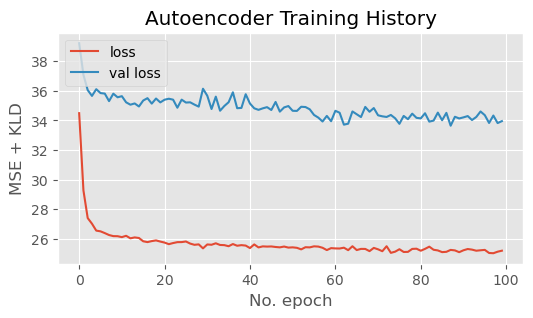

5677/5677 [==============================] - 10s 2ms/step
Accuracy:, 0.999390 (+/- 0.000038)
Precision: 0.854359 (+/- 0.020284)
Recall: 0.781564 (+/- 0.038215)
F1 score: 0.815416 (+/- 0.016631)
ROC_AUC: 0.890666 (+/- 0.019089)
Best hyperparameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}


In [13]:
#With hyperparameter tuning
#Cross validation
skf = StratifiedKFold(n_splits=5)

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize variables to store the best hyperparameters and AUC score
best_params = {}
best_scores = []
best_f1 = -np.inf

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    lst_accuracy = []
    lst_precision = []
    lst_recall = []
    lst_f1_score = []
    lst_roc_auc_score = []
    
    f1_scores = []

    model = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'])

    print("############################### Parameters tested:", params,"################################")
    for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        print("------------------------ KFold:", count+1, "---------------------------")
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
        print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
        
        maj = len(y_train_fold[y_train_fold == 0])
        mino = len(y_train_fold[y_train_fold == 1])
        frac = 0.5
        num_samples = round(1/(1/frac - 1) * maj - mino)

        print("Number of samples to be generated: ", num_samples)

        # Variational Oversampling 
        vos = VAE_oversampling(hidden_dim= 64,
                                latent_dim=2,
                                original_dim=30,
                                minority_class_id=1,
                                epochs=100,
                                batch_size=1,
                                num_samples_to_generate = num_samples,
                                random_state = 0,
                                optimizer="adam")
        
  

        #Fit the VAE oversampling model and get new data set
        X_res_val,y_res_val = vos.fit_sample(X_train_fold,y_train_fold)
        
        std = StandardScaler()

        X_train_processed = std.fit_transform(X_res_val) 
        X_valid_processed = std.transform(X_valid_fold)

        model.fit(X_train_processed, y_res_val)

        y_pred_test = model.predict(X_valid_processed)

        lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
        lst_precision.append(precision_score(y_valid_fold, y_pred_test))
        lst_recall.append(recall_score(y_valid_fold, y_pred_test))
        lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
        lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


    avg_f1 = np.mean(lst_f1_score)

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_scores = [lst_accuracy, lst_precision, lst_recall, lst_f1_score, lst_roc_auc_score]
        best_params = params

# Print the best AUC score and hyperparameters
print(f"Accuracy:, {np.mean(best_scores[0]):0.6f} (+/- {np.std(best_scores[0]):0.6f})")
print(f"Precision: {np.mean(best_scores[1]):0.6f} (+/- {np.std(best_scores[1]):0.6f})")
print(f"Recall: {np.mean(best_scores[2]):0.6f} (+/- {np.std(best_scores[2]):0.6f})")
print(f"F1 score: {np.mean(best_scores[3]):0.6f} (+/- {np.std(best_scores[3]):0.6f})")
print(f"ROC_AUC: {np.mean(best_scores[4]):0.6f} (+/- {np.std(best_scores[4]):0.6f})")
print("Best hyperparameters:", best_params)


### Cross Validation

------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
NUmber of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 5ms/step - loss: 35.5325 - val_loss: 30.4985
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 30.7902 - val_loss: 26.3365
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 28.7932 - val_loss: 25.4404
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 28.1981 - val_loss: 25.6052
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 27.8985 - val_loss: 25.4119
Epoch 6/100
284/284 [==============================] - 1s 3ms/step - loss: 27.8465 - val_loss: 25.2575
Epoch 7/100
284/284 [==============================] - 1s 3ms/step - loss: 27

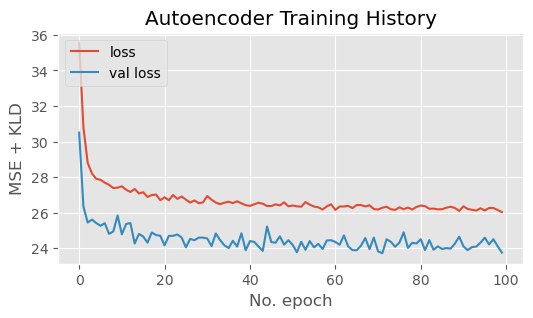

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.2501 - val_loss: 27.5718
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.6881 - val_loss: 25.3521
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4936 - val_loss: 25.0213
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1373 - val_loss: 24.8395
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2788 - val_loss: 24.8588
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9614 - val_loss: 24.7241
Epoch 7/100
283/283 

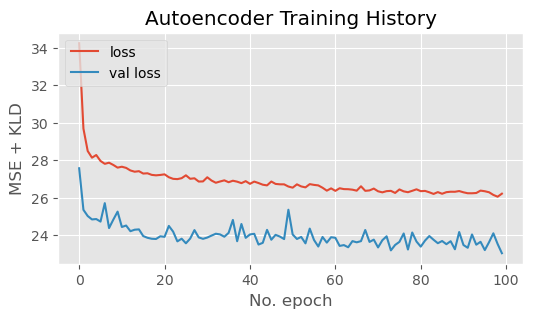

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.0802 - val_loss: 28.2591
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.9436 - val_loss: 25.1717
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6594 - val_loss: 24.5874
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6883 - val_loss: 24.6497
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0993 - val_loss: 24.5858
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0954 - val_loss: 24.1449
Epoch 7/100
283/283 

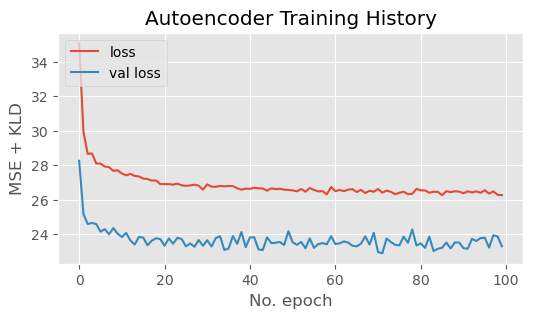

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 35.4831 - val_loss: 30.5819
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.3774 - val_loss: 27.0215
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4309 - val_loss: 25.9801
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0496 - val_loss: 26.0550
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8219 - val_loss: 25.7936
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8197 - val_loss: 25.6371
Epoch 7/100
283/283 

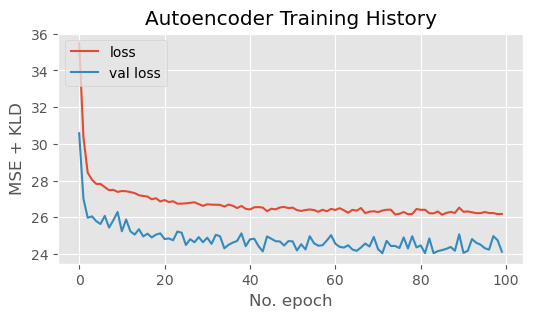

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 6ms/step - loss: 33.9913 - val_loss: 39.0932
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.1880 - val_loss: 36.2668
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 27.2349 - val_loss: 35.9018
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 27.0357 - val_loss: 35.9200
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 26.6032 - val_loss: 35.6793
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 26.6442 - val_loss: 36.0847
Epoch 7/100
283/283

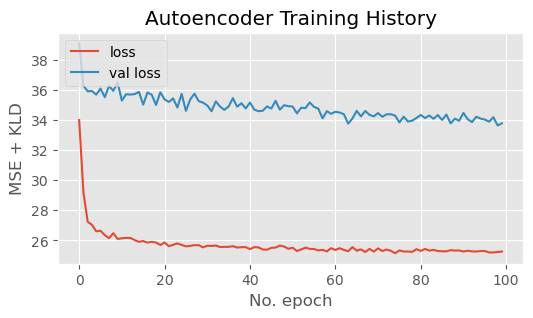

5677/5677 [==============================] - 12s 2ms/step


In [11]:
#Cross validation
skf = StratifiedKFold(n_splits=5)
lst_accuracy = []
lst_precision = []
lst_recall = []
lst_f1_score = []
lst_roc_auc_score = []

model = SVC()

for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    print("------------------------ KFold:", count+1, "---------------------------")
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
    print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
    
    maj = len(y_train_fold[y_train_fold == 0])
    mino = len(y_train_fold[y_train_fold == 1])
    frac = 0.5
    num_samples = round(1/(1/frac - 1) * maj - mino)

    print("NUmber of samples to be generated: ", num_samples)

    # Variational Oversampling 
    vos = VAE_oversampling(hidden_dim= 64,
                            latent_dim=2,
                            original_dim=30,
                            minority_class_id=1,
                            epochs=100,
                            batch_size=1,
                            num_samples_to_generate = num_samples,
                            random_state = 0,
                            optimizer="adam")

    #Fit the VAE oversampling model and get new data set
    X_res_val,y_res_val = vos.fit_sample(X_train_fold,y_train_fold)
    
    std = StandardScaler()
    
    X_train_processed = std.fit_transform(X_res_val) 
    X_valid_processed = std.transform(X_valid_fold)

    model.fit(X_train_processed, y_res_val)

    y_pred_test = model.predict(X_valid_processed)

    lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
    lst_precision.append(precision_score(y_valid_fold, y_pred_test))
    lst_recall.append(recall_score(y_valid_fold, y_pred_test))
    lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
    lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


In [12]:
print(f"Accuracy:, {np.mean(lst_accuracy):0.6f} (+/- {np.std(lst_accuracy):0.6f})")
print(f"Precision: {np.mean(lst_precision):0.6f} (+/- {np.std(lst_precision):0.6f})")
print(f"Recall: {np.mean(lst_recall):0.6f} (+/- {np.std(lst_recall):0.6f})")
print(f"F1 score: {np.mean(lst_f1_score):0.6f} (+/- {np.std(lst_f1_score):0.6f})")
print(f"ROC_AUC: {np.mean(lst_roc_auc_score):0.6f} (+/- {np.std(lst_roc_auc_score):0.6f})")

Accuracy:, 0.999320 (+/- 0.000037)
Precision: 0.907407 (+/- 0.024414)
Recall: 0.677540 (+/- 0.046677)
F1 score: 0.774122 (+/- 0.021171)
ROC_AUC: 0.838708 (+/- 0.023317)


### One fit

Epoch 1/100
354/354 [==============================] - 2s 4ms/step - loss: 33.6678 - val_loss: 25.8653
Epoch 2/100
354/354 [==============================] - 1s 3ms/step - loss: 29.3683 - val_loss: 23.9919
Epoch 3/100
354/354 [==============================] - 1s 3ms/step - loss: 28.5344 - val_loss: 23.9801
Epoch 4/100
354/354 [==============================] - 1s 3ms/step - loss: 28.2976 - val_loss: 23.3475
Epoch 5/100
354/354 [==============================] - 1s 3ms/step - loss: 27.8588 - val_loss: 23.4060
Epoch 6/100
354/354 [==============================] - 1s 3ms/step - loss: 27.8176 - val_loss: 23.5880
Epoch 7/100
354/354 [==============================] - 1s 3ms/step - loss: 27.8209 - val_loss: 23.7741
Epoch 8/100
354/354 [==============================] - 1s 3ms/step - loss: 27.6769 - val_loss: 23.8379
Epoch 9/100
354/354 [==============================] - 1s 3ms/step - loss: 27.5351 - val_loss: 23.1233
Epoch 10/100
354/354 [==============================] - 1s 3ms/step - los

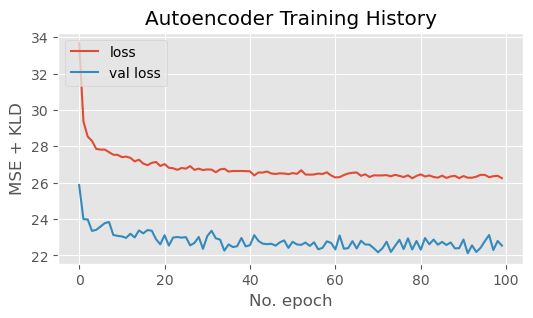

7096/7096 [==============================] - 12s 2ms/step


In [8]:
maj = len(y_train[y_train == 0])
mino = len(y_train[y_train == 1])
frac = 0.5
num_samples = round(1/(1/frac - 1) * maj - mino)

# Variational Oversampling 
vos = VAE_oversampling(hidden_dim= 64,
                        latent_dim=2,
                        original_dim=30,
                        minority_class_id=1,
                        epochs=100,
                        batch_size=1,
                        num_samples_to_generate = num_samples,
                        random_state = 0,
                        optimizer="adam")

#Fit the VAE oversampling model and get new data set
X_res_val,y_res_val = vos.fit_sample(X_train,y_train)

std = StandardScaler()

X_train_processed = std.fit_transform(X_res_val) 
X_test_processed = std.transform(X_test)

In [9]:
pd.DataFrame(X_res_val)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,161919.000000,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.320000
1,124477.000000,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.990000
2,41191.000000,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,...,1.280856,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.100000
3,132624.000000,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,...,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.100000
4,59359.000000,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,...,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454897,83159.195312,-2.033702,3.589421,-2.945578,4.593170,-1.849406,-0.684984,-1.747113,0.588279,-1.275228,...,0.358018,0.641341,0.051318,-0.060161,-0.109107,0.019606,0.047838,0.170788,0.096198,267.514893
454898,82832.179688,-4.707807,7.889394,-7.068378,7.471152,-3.101629,-1.387192,-5.539909,2.738250,-2.589654,...,0.817842,0.725899,0.818772,-0.062790,0.350466,0.019602,0.048682,0.159445,0.077217,125.591469
454899,82832.179688,-4.707792,7.892416,-7.068378,7.472758,-3.101606,-1.387192,-5.539909,0.588240,-2.589654,...,1.736693,0.628824,1.496653,-0.062790,-0.108610,0.034316,0.495890,0.995804,0.077212,125.591469
454900,110577.187500,-1.262899,3.588769,-3.635028,4.599038,0.450555,-1.372181,-2.607490,0.593148,-1.750241,...,0.358576,0.628815,0.051318,-0.062790,-0.109108,0.041252,0.074842,0.198015,0.077395,125.592743


In [10]:
svc_vae = SVC()

svc_vae.fit(X_train_processed, y_res_val)

#predict
pred_lr_vae_val = svc_vae.predict(X_test_processed)

model_scores(y_test, pred_lr_vae_val)

Accuracy: 0.9993504441557529
Precision: 0.8961038961038961
Recall: 0.7040816326530612
F1 score: 0.7885714285714286
ROC_AUC: 0.8519704730513478
